###  **User Engagement Analysis**
In this task we will track the user’s engagement using the following engagement metrics: 
* Sessions frequency 
* Duration of the session 
* Sessions total traffic (download and upload (MB))


In [29]:
# Import libraries

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go  
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, normalize

In [2]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from df_outlier import *
import plots

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# Read cleaned Telecom dataset

cleaned_df = pd.read_csv('../data/cleaned_Telecom_data.csv')
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      148506 non-null  int64  
 1   Unnamed:_0                      148506 non-null  int64  
 2   Bearer_Id                       148506 non-null  float64
 3   Start                           148506 non-null  object 
 4   Start_ms                        148506 non-null  float64
 5   End                             148506 non-null  object 
 6   End_ms                          148506 non-null  float64
 7   Dur._(ms)                       148506 non-null  float64
 8   IMSI                            148506 non-null  float64
 9   MSISDN_Number                   148506 non-null  float64
 10  IMEI                            148506 non-null  float64
 11  Last_Location_Name              148506 non-null  object 
 12  Avg_RTT_DL_(ms) 

### Task 2
Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric

In [5]:
user_engagement_df = cleaned_df[['MSISDN_Number', 'Bearer_Id', 'Dur._(ms)', 'Total_Data_(Bytes)']].copy().rename(columns={
    'Bearer_Id': 'Session_Frequency', 'MSISDN_Number':'Customer_Id', 'Dur._(ms)': 'Duration', 'Total_Data_(Bytes)': 'Total_Data_Volume'})

In [6]:

user_engagement = user_engagement_df.groupby('Customer_Id').agg({'Session_Frequency': 'count', 'Duration': 'sum', 'Total_Data_Volume': 'sum'})
user_engagement.head(10)

,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,
33601001722.00,1,116720.00,878690574.00
33601001754.00,1,181230.00,156859643.00
33601002511.00,1,134969.00,595966483.00
33601007832.00,1,49878.00,422320698.00
33601008617.00,2,37104.00,1457410944.00
33601010682.00,2,253983.00,615217221.00
33601011634.00,2,128360.00,654723066.00
33601011959.00,1,86399.00,332660357.00
33601014694.00,2,242249.00,990132189.00


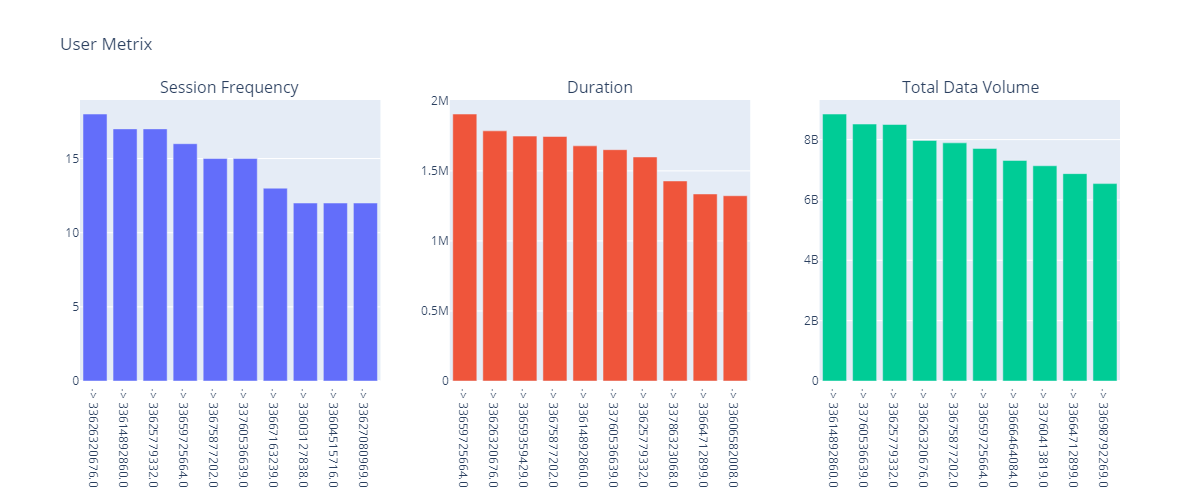

In [7]:
sessions = user_engagement.nlargest(10, "Session_Frequency")['Session_Frequency']
duration = user_engagement.nlargest(10, "Duration")['Duration']
total_data_volume = user_engagement.nlargest(10, "Total_Data_Volume")['Total_Data_Volume']

plots.mult_hist([sessions, duration, total_data_volume], 1,
          3, "User Metrix", ['Session Frequency', 'Duration', 'Total Data Volume'])

Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement

<AxesSubplot:>

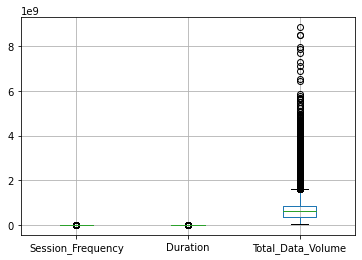

In [8]:
# Check for outliers 

user_engagement.boxplot()

<AxesSubplot:>

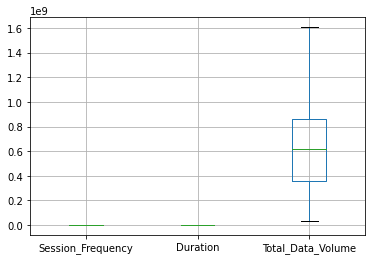

In [9]:
# Remove Outliers

replace_outliers_with_iqr(user_engagement, ['Session_Frequency', 'Duration', 'Total_Data_Volume'])
user_engagement.boxplot()

#### Normalize the Engagement Metrics

In [10]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(user_engagement)
pd.DataFrame(scaled_array).head(5)

,0,1,2
0,-0.55,-0.07,0.54
1,-0.55,0.74,-1.28
2,-0.55,0.16,-0.17
3,-0.55,-0.92,-0.61
4,0.98,-1.08,2.00


In [11]:
data_normalized = normalize(scaled_array)
pd.DataFrame(data_normalized).head(5)

,0,1,2
0,-0.71,-0.09,0.70
1,-0.35,0.47,-0.81
2,-0.92,0.26,-0.29
3,-0.45,-0.74,-0.50
4,0.39,-0.44,0.81


In [12]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_normalized)
kmeans.labels_

array([2, 1, 1, ..., 1, 2, 1])

In [13]:
user_engagement.insert(0, 'Cluster', kmeans.labels_)
user_engagement.head(5)

,Cluster,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,,
33601001722.00,2,1.00,116720.00,878690574.00
33601001754.00,1,1.00,181230.00,156859643.00
33601002511.00,1,1.00,134969.00,595966483.00
33601007832.00,1,1.00,49878.00,422320698.00
33601008617.00,0,2.00,37104.00,1457410944.00


In [14]:
user_engagement['Cluster'].value_counts()

1    42664
2    32253
0    31554
Name: Cluster, dtype: int64

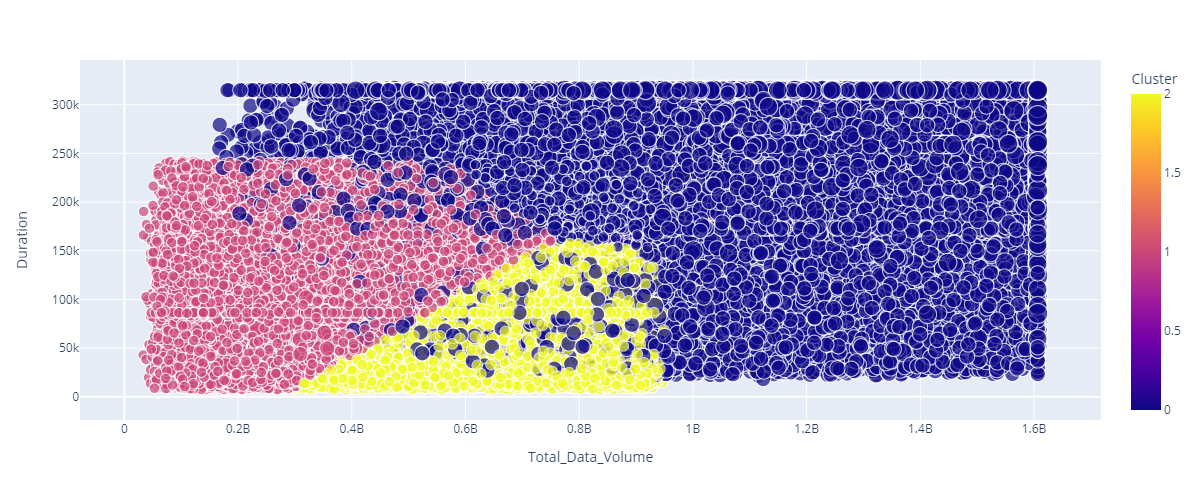

In [15]:
fig = px.scatter(user_engagement, x='Total_Data_Volume', y="Duration", color='Cluster', size='Session_Frequency')
Image(pio.to_image(fig, format='png', width=1200))

Compute the minimum, maximum, average & total non-normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.

In [16]:
cluster1 = user_engagement[user_engagement["Cluster"]==0]
cluster1.describe()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,31554.00,31554.00,31554.00,31554.00
mean,0.00,2.21,199194.95,1090343059.47
std,0.00,0.65,84616.57,366972119.04
min,0.00,1.00,18235.00,156647546.00
25%,0.00,2.00,146526.75,808492038.00
50%,0.00,2.00,189009.00,1064961835.00
75%,0.00,2.00,271109.75,1428302783.50
max,0.00,3.50,314925.75,1606535056.25


In [17]:
cluster1 = user_engagement[user_engagement["Cluster"]==1]
cluster1.describe()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,42664.00,42664.00,42664.00,42664.00
mean,1.00,1.01,106853.55,323825277.35
std,0.00,0.08,49957.46,161262880.62
min,1.00,1.00,7189.00,33249009.00
25%,1.00,1.00,85799.75,190274894.00
50%,1.00,1.00,94889.50,306922716.00
75%,1.00,1.00,144925.00,442423054.75
max,1.00,2.00,241989.00,758539603.00


In [18]:
cluster1 = user_engagement[user_engagement["Cluster"]==2]
cluster1.describe()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,32253.00,32253.00,32253.00,32253.00
mean,2.00,1.00,68110.82,697315477.32
std,0.00,0.03,36980.33,142249608.94
min,2.00,1.00,7142.00,300596420.00
25%,2.00,1.00,31962.00,595791313.00
50%,2.00,1.00,82503.00,712225253.00
75%,2.00,1.00,86422.00,814512780.00
max,2.00,2.00,160575.00,950760661.00


Aggregate user total traffic per application and derive the top 10 most engaged users per application

In [19]:
app_df = cleaned_df.groupby('MSISDN_Number').agg({'Gaming_(Bytes)': 'sum', 'Youtube_(Bytes)': 'sum', 'Netflix_(Bytes)': 'sum',\
                     'Google_(Bytes)': 'sum', 'Email_(Bytes)': 'sum', 'Social_Media_(Bytes)': 'sum', 'Other_(Bytes)': 'sum'})
app_df.head()

,Gaming_(Bytes),Youtube_(Bytes),Netflix_(Bytes),Google_(Bytes),Email_(Bytes),Social_Media_(Bytes),Other_(Bytes)
MSISDN_Number,,,,,,,
33601001722.00,812458661.00,21624548.00,27180981.00,4389005.00,1331362.00,2232135.00,386570872.00
33601001754.00,119750078.00,12432223.00,11221763.00,5334863.00,3307781.00,2660565.00,281710071.00
33601002511.00,538827713.00,21333570.00,19353900.00,3443126.00,3205380.00,3195623.00,501693672.00
33601007832.00,391126127.00,6977321.00,1942092.00,9678493.00,2284670.00,280294.00,35279702.00
33601008617.00,1314797820.00,41533002.00,49201724.00,18499616.00,3305469.00,2912542.00,804804484.00


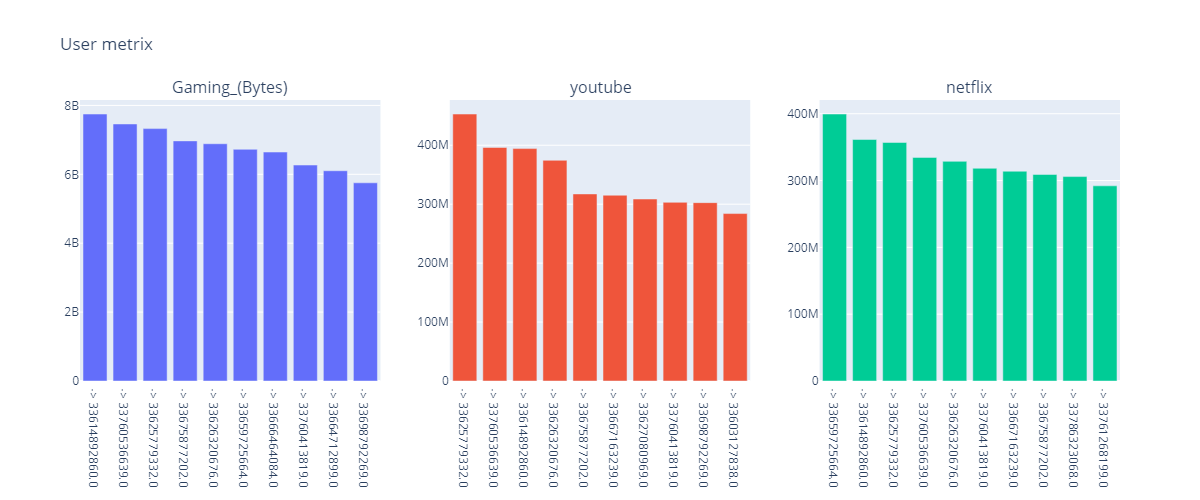

In [20]:
gaming = app_df.nlargest(10, "Gaming_(Bytes)")['Gaming_(Bytes)']
youtube = app_df.nlargest(10, "Youtube_(Bytes)")['Youtube_(Bytes)']
netflix = app_df.nlargest(10, "Netflix_(Bytes)")['Netflix_(Bytes)']
google = app_df.nlargest(10, "Google_(Bytes)")['Google_(Bytes)']
email = app_df.nlargest(10, "Email_(Bytes)")['Email_(Bytes)']
social_media = app_df.nlargest(10, "Social_Media_(Bytes)")['Social_Media_(Bytes)']
other = app_df.nlargest(10, "Other_(Bytes)")['Other_(Bytes)']


plots.mult_hist([gaming, youtube, netflix], 1,
          3, "User metrix", ["Gaming_(Bytes)", "youtube", "netflix"])

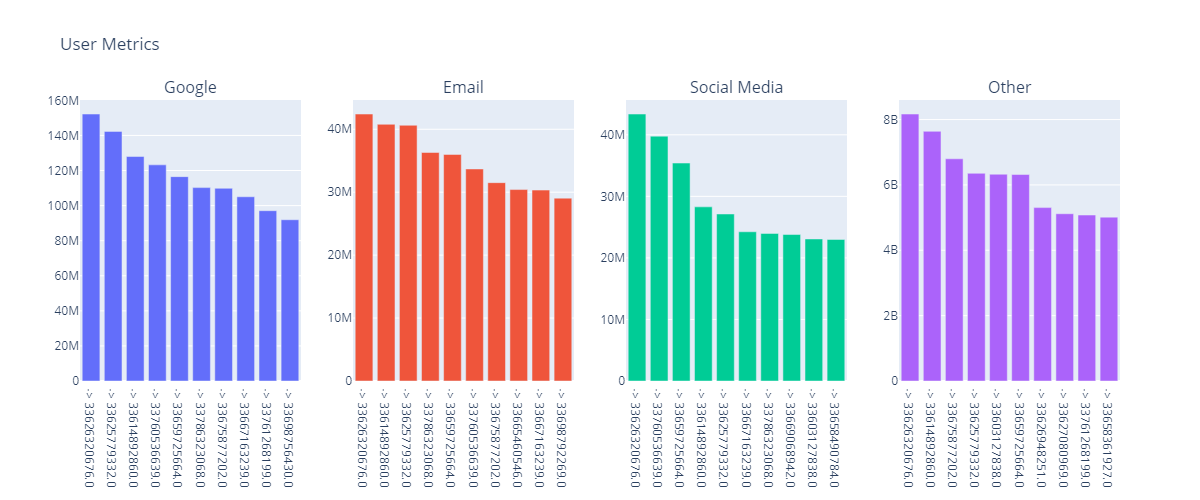

In [21]:
plots.mult_hist([google, email, social_media, other], 1,
          4, "User Metrics", [ "Google", "Email", "Social Media", "Other"])

##### Top 3 most used Applications

In [22]:
top_3 = app_df.sum()
top_3

Gaming_(Bytes)         63910124731666.00
Youtube_(Bytes)         3362537620065.00
Netflix_(Bytes)         3360563670772.00
Google_(Bytes)          1159544186717.00
Email_(Bytes)            335503000148.00
Social_Media_(Bytes)     271478798103.00
Other_(Bytes)          63770726326023.00
dtype: float64

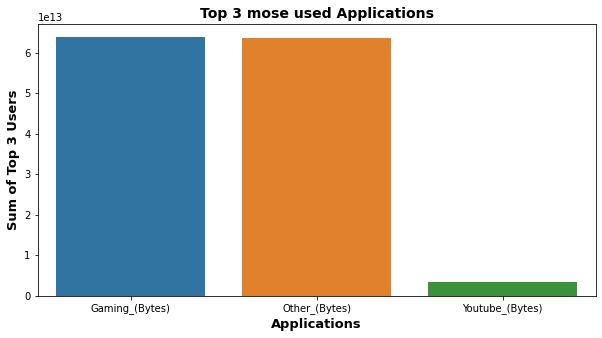

In [23]:
plots.plot_bar(top_3.nlargest(3), "Top 3 mose used Applications", "Applications", "Sum of Top 3 Users")

Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics. 
- What is the optimized value of k(use elbow method for this)?
- Interpret your findings.


In [24]:
# Distortion- average of the euclidean squared distance from the centroid of the respective clusters. 
# Inertia - sum of squared distances of samples to their closest cluster centre.

def choose_kmeans(df: pd.DataFrame, num: int):
  distortions = []
  inertias = []
  K = range(1, num)
  for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
    distortions.append(sum(
        np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
    inertias.append(kmeans.inertia_)

  return (distortions, inertias)

In [25]:
distortions, inertias = choose_kmeans(data_normalized, 15)

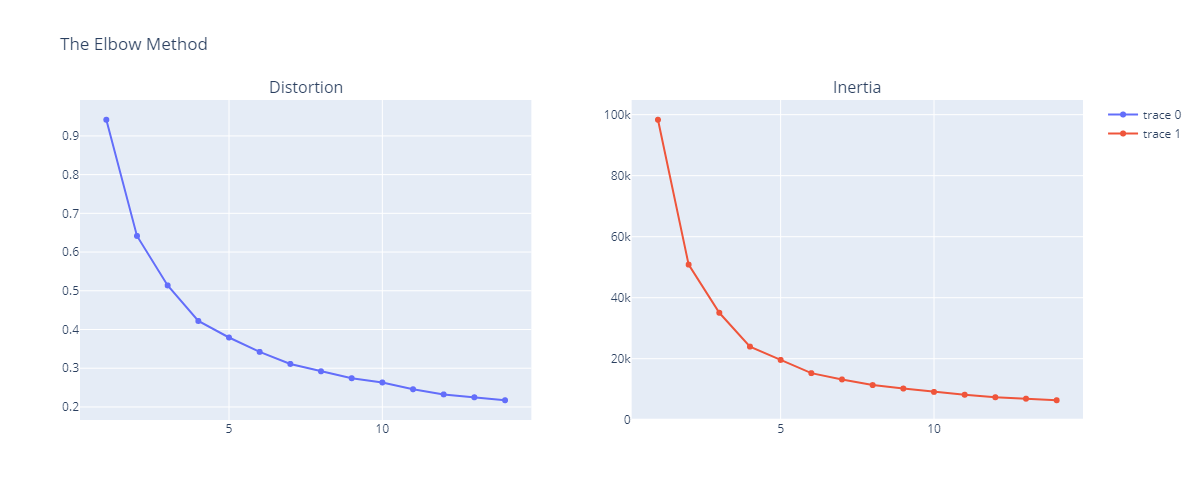

In [30]:
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Distortion", "Inertia")
)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=distortions), row=1, col=1)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=inertias), row=1, col=2)
fig.update_layout(title_text="The Elbow Method")
# fig.show(config=config)
Image(pio.to_image(fig, format='png', width=1200))

From this plot we can see that 4 cluster value is optimal because there is not significant decrease in distortion and inertia.

In [31]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(data_normalized)
user_engagement["Cluster"]= kmeans.labels_
user_engagement

,Cluster,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,,
33601001722.00,3,1.00,116720.00,878690574.00
33601001754.00,2,1.00,181230.00,156859643.00
33601002511.00,2,1.00,134969.00,595966483.00
33601007832.00,0,1.00,49878.00,422320698.00
33601008617.00,1,2.00,37104.00,1457410944.00
...,...,...,...,...
33789996170.00,3,1.00,8810.00,714641641.00
33789997247.00,2,1.00,140988.00,480307335.00
3197020876596.00,0,1.00,86399.00,232123971.00


#### Save the Model  

In [32]:
with open("../models/user_engagement.pkl", "wb") as f:
    pickle.dump(kmeans, f)

##### Save the User Engagement CSV File

In [ ]:
user_engagement.to_csv('../data/user_engagement.csv')